# **Capstone Project (Week 2): Find the Best City and Neighborhood to set a Bakery Shop business**
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Under Study](#introduction)
* [Data Description](#data)
* [Methodology](#methodology)
* [Results & Discussion & Conclusion](#results)

## 1. Introduction: Business Under Study <a name="introduction"></a>

In this project we advise an investor who is trying to find out where to open a **Bakery Shop in the United States**. He wants to find the **best city in terms of population and income per capita**, where he knows the people spends more; and then compare neighborhoods and their venues to decide where to put his store.

It reasonable to suppose there are lots of food venues in big cities centers, so we will try to detect **locations that are not already crowded with them**. We are also particularly interested in **neighborhoods with less/no bakeries in it**. We would also prefer locations **as close to city center as possible**.

We will use our data science powers to determine the best cities and the most promising neighborhoods based on these criteria. Advantages of each area will then be expressed so that best possible final location can be chosen by our investor.

## 2. Data Description <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* more crowded and better income per capita cities in the US
* potential competing food venues in each neighborhood (we will consider only the top 10 venues)
* any Bakery shop in the top 10 of the neighborhoods?
* distance of neighborhood from city center (from observation)

Following data sources will be needed to extract/generate the required information:
* top populated US cities with better per capita income, will be obtained by **web scrapping** using BeautifulSoup
* neighborhoods in the chosen cities, will be obtained by **Wikipedia web scrapping** using BeautifulSoup
* cities and neighborhoods location data, will be obtained using **Nominatim geocoding**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**
* representation maps using Folium
* representation graphs using Plotly and Matplotlib

## 3. Methodology <a name="methodology"></a>

### 3.1 Procedure steps

For this study, our First step is searching for USA most populated cities with higher per capita income. From those 
candidates cities, we’ll choose the top 2 for simplification. We are going to individualize each neighborhood and obtain 
its coordinates in both. We’ll do a map representation of them.

Second step is to explore every neighborhood in terms of venues. We are going to find out the most popular venues

Now with steps One and Two completed, we’re in condition of clean and merge the gathered information.

So, our Third step is to analyze and prepare the venues data of the neighborhoods in the chosen cities. We are going to 
consider the top 10 most common venues. We are particularly interested in food categories, highlighting bakeries if 
any.

Fourth step is clustering the neighborhoods through a machine learning model, in order to understand and compare 
them.

Finally, our Fifth step is to examine each group and determine the discriminating venue categories that distinguish each 
one.

Then, with a little help of calculations and simple plots on the previous information, we will be in a good position to 
recommend the best for the investor.

### 3.2 Steps Developing: Obtaining the info and workflow explanation

#### 3.2.1 STEP 1: Scraping info, building and cleaning the dataframes

In [1]:
#!pip install bs4
#!pip install requests

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)

#### Scraping for cities data


Discovering the cities with the highest income:

In [3]:
#The below url contains html tables with income per capita in the top populated cities in the USA in year 2019
url = "https://www.statista.com/statistics/205618/per-capita-income-in-the-top-20-most-populated-cities-in-the-us/"

# get the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

#find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [4]:
len(tables)

2

In [5]:
#tables[0]

In [6]:
table_contents=[]
table=tables[0]

total_td=table.findAll('td')

for i in range(len(total_td)):
    if i%2==0:
        cell = {}
    
        cell['City'] = total_td[i].text.strip()
        cell['Per capita income 2019'] = total_td[i+1].text.strip()
        table_contents.append(cell)
    

df=pd.DataFrame(table_contents)


In [7]:
df

,City,Per capita income 2019
0,"San Francisco city, California","75,084"
1,"Seattle city, Washington","65,205"
2,"Washington city, District of Columbia","59,808"
3,"San Jose city, California","51,310"
4,"Boston city, Massachusetts","48,978"
5,"Denver city, Colorado","47,802"
6,"Austin city, Texas","46,217"
7,"San Diego city, California","43,249"
8,"New York city, New York","43,046"
9,"Chicago city, Illinois","40,277"


We only consider the Top 2 most populated and better income cities:

In [8]:
cities = df[0:2]
cities

,City,Per capita income 2019
0,"San Francisco city, California","75,084"
1,"Seattle city, Washington","65,205"


#### Scraping for neighborhoods in the chosen cities

Scrapping SAN FRANCISCO

In [9]:
url_sf = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco"

data_sf  = requests.get(url_sf).text
soup_sf = BeautifulSoup(data_sf,"html5lib")
tables_sf = soup_sf.find_all('table')
len(tables_sf)

3

In [10]:
#tables_sf[2]

In [11]:
n = soup_sf.find_all("span",class_="toctext")
#n

In [12]:
len(n)

123

In [13]:
table_sf=[]

for i in n:
    cell = {}
    if i.text=='References' or i.text=='See also' or i.text=='External links' or i.text=='Specific neighborhoods':
        pass
    else:
        cell['Neighborhood'] = i.text
        #cell['Borough'] = (row.span.text).split('(')[0]
        #cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_sf.append(cell)

df_sf=pd.DataFrame(table_sf)

In [14]:
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [15]:
latitude=[]
longitude=[]

for code in df_sf['Neighborhood']:
    g = geocoder.arcgis('{}, San Francisco, CA'.format(code))
    #print(code, g.latlng)
    while (g.latlng is None):
        g = geocoder.google('{}, San Francisco, CA'.format(code))
        #print(code, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

In [16]:
df_sf['Latitude']=latitude
df_sf['Longitude']=longitude

In [17]:
df_sf

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.777220,-122.431460
1,Anza Vista,37.780480,-122.443580
2,Ashbury Heights,37.764870,-122.445900
3,Balboa Hollow,37.775890,-122.493600
4,Balboa Terrace,37.731800,-122.467400
5,The Bayview,37.733450,-122.389980
6,Belden Place,37.791275,-122.403785
7,Bernal Heights,37.739040,-122.416250
8,Buena Vista,37.806468,-122.420867
9,Butchertown (Old and New),37.777120,-122.419640


Scrapping SEATTLE

In [18]:
url_s = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle"

data_s  = requests.get(url_s).text
soup_s = BeautifulSoup(data_s,"html5lib")
tables_s = soup_s.find_all('table')
len(tables_s)

4

In [19]:
#tables_s[0]

In [20]:
table_contents2=[]
table2=tables_s[0]

total_td=table2.findAll('td')

for i in range(len(total_td)):
        cell = {}
               
        cell['Neighborhood'] = total_td[i].text.strip()
        table_contents2.append(cell)
       
df_se=pd.DataFrame(table_contents2)


In [21]:
df_se

,Neighborhood
0,North Seattle
1,Seattle
2,Various
3,
4,
5,
6,North of the Lake Washington Ship Canal[42]
7,Broadview
8,North Seattle[42]
9,1954[43]


In [22]:
#cleaning the info

df_se = df_se.iloc[lambda x: x.index % 7 == 0]
df_se.reset_index(drop=True, inplace=True)
#df_se

In [23]:
len(df_se)

127

In [24]:
latitude2=[]
longitude2=[]

for code in df_se['Neighborhood']:
    g = geocoder.arcgis('{}, Seattle, WA'.format(code))
    #print(code, g.latlng)
    while (g.latlng is None):
        g = geocoder.google('{}, Seattle, WA'.format(code))
        #print(code, g.latlng)
    latlng = g.latlng
    latitude2.append(latlng[0])
    longitude2.append(latlng[1])

In [25]:
df_se['Latitude']=latitude2
df_se['Longitude']=longitude2

<ipython-input-25-7a37a8aaf546>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_se['Latitude']=latitude2
<ipython-input-25-7a37a8aaf546>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_se['Longitude']=longitude2


In [26]:
df_se

,Neighborhood,Latitude,Longitude
0,North Seattle,47.643724,-122.302937
1,Broadview,47.722380,-122.364980
2,Bitter Lake,47.718680,-122.350300
3,North Beach / Blue Ridge,47.700440,-122.384180
4,Crown Hill,47.695200,-122.374100
5,Greenwood,47.690820,-122.355290
6,Northgate,47.713100,-122.319300
7,Haller Lake,47.723200,-122.338700
8,Pinehurst,47.718940,-122.314000
9,North College Park\n(Licton Springs),47.698550,-122.337630


In [27]:
df_se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  127 non-null    object 
 1   Latitude      127 non-null    float64
 2   Longitude     127 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [28]:
#IMPORTING MORE NECESSARY LIBRARIES

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### MAPS OF SAN FRANCISCO AND SEATTLE

#### Use geopy library to get the latitude and longitude values of SAN FRANCISCO.

In [29]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.419906.


#### Create a map of SAN FRANCISCO with neighborhoods superimposed on top.

In [30]:
map_sf = folium.Map(location=[latitude, longitude], zoom_start=10)

We add the markers and show the map...

In [31]:
# add markers to map
for neighborhood, lat, lng in zip(df_sf['Neighborhood'], df_sf['Latitude'], df_sf['Longitude']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#81cc31',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

I rule out outliers locations from the dataframe...

In [32]:
df_sf.index[df_sf['Neighborhood'] == 'Vista del Mar']

Int64Index([113], dtype='int64')

In [33]:
df_sf.index[df_sf['Neighborhood'] == 'Cathedral Hill']

Int64Index([11], dtype='int64')

In [37]:
df_sf.index[df_sf['Neighborhood'] == 'Treasure Island']

Int64Index([107], dtype='int64')

In [38]:
df_sf.index[df_sf['Neighborhood'] == 'Little Saigon']

Int64Index([57], dtype='int64')

In [39]:
df_sf.drop([113,11,107,57], inplace = True)
df_sf.reset_index(drop=True, inplace=True)

In [40]:
df_sf

,Neighborhood,Latitude,Longitude
0,Alamo Square,37.777220,-122.431460
1,Anza Vista,37.780480,-122.443580
2,Ashbury Heights,37.764870,-122.445900
3,Balboa Hollow,37.775890,-122.493600
4,Balboa Terrace,37.731800,-122.467400
5,The Bayview,37.733450,-122.389980
6,Belden Place,37.791275,-122.403785
7,Bernal Heights,37.739040,-122.416250
8,Buena Vista,37.806468,-122.420867
9,Butchertown (Old and New),37.777120,-122.419640


#### Use geopy library to get the latitude and longitude values of SEATTLE.

In [41]:
address2 = 'Seattle, WA'

geolocator = Nominatim(user_agent="to_explorer")
location2 = geolocator.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinates of Seattle are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinates of Seattle are 47.6038321, -122.3300624.


#### Create a map of SEATTLE with neighborhoods superimposed on top.

In [42]:
map_se = folium.Map(location=[latitude2, longitude2], zoom_start=10)

We add the markers and show the map...

In [43]:
# add markers to map
for neighborhood, lat, lng in zip(df_se['Neighborhood'], df_se['Latitude'], df_se['Longitude']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#2ba6ed',
        fill_opacity=0.7,
        parse_html=False).add_to(map_se)  
    
map_se

In [44]:
df_se.index[df_se['Neighborhood'] == 'Cascade, Seattle']

Int64Index([63], dtype='int64')

In [45]:
df_se.index[df_se['Neighborhood'] == 'Madrona Valley']

Int64Index([84], dtype='int64')

In [46]:
df_se.index[df_se['Neighborhood'] == 'Harbor Island']

Int64Index([106], dtype='int64')

In [47]:
df_se.index[df_se['Neighborhood'] == 'Renton Hill']

Int64Index([58], dtype='int64')

In [48]:
df_se.drop([63,84,106,58], inplace = True)
df_se.reset_index(drop=True, inplace=True)

C:\Users\la02922\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
df_se

,Neighborhood,Latitude,Longitude
0,North Seattle,47.643724,-122.302937
1,Broadview,47.722380,-122.364980
2,Bitter Lake,47.718680,-122.350300
3,North Beach / Blue Ridge,47.700440,-122.384180
4,Crown Hill,47.695200,-122.374100
5,Greenwood,47.690820,-122.355290
6,Northgate,47.713100,-122.319300
7,Haller Lake,47.723200,-122.338700
8,Pinehurst,47.718940,-122.314000
9,North College Park\n(Licton Springs),47.698550,-122.337630


#### 3.2.2 STEP 2: Exploring venues

We will use the **explore** function of the Foursquare API to get the most common **venues** in each neighborhood from
SAN FRANCISCO and from SEATTLE.
Let's get the top 50 venues within a radius of 500 meters. Why we chose 500 meters radius: Observing the map we see 
that some neighborhoods are very close each other, there may be venues overlapping at greater distance, so 500 mts 
seems to be a reasonable value to consider and prevent it a bit

Define Foursquare Credentials and Version

In [267]:
# The credentials were removed for sharing.

CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)


In [51]:
import json # library to handle JSON files

In [52]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Now, let's get the top 50 venues that are in each neghborhood within a radius of 500 meters.

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now, the code to run the above function on each neighborhood in SAN FRANCISCO and create a new dataframe called "san_francisco_venues"

In [54]:
san_francisco_venues = getNearbyVenues(names=df_sf['Neighborhood'],
                                   latitudes=df_sf['Latitude'],
                                   longitudes=df_sf['Longitude']
                                  )

Alamo Square
Anza Vista
Ashbury Heights
Balboa Hollow
Balboa Terrace
The Bayview
Belden Place
Bernal Heights
Buena Vista
Butchertown (Old and New)
The Castro
Cayuga Terrace
China Basin
Chinatown
Civic Center
Clarendon Heights
Cole Valley
Corona Heights
Cow Hollow
Crocker-Amazon
Design District
Diamond Heights
Dogpatch
Dolores Heights
Duboce Triangle
The Embarcadero
Eureka Valley
The Excelsior
The Fillmore
The Financial District
The Financial District South
Fisherman's Wharf
Forest Hill
Forest Knolls
Glen Park
Golden Gate Heights
The Haight
Hayes Valley
Hunters Point
India Basin
Ingleside
Ingleside Terraces
The Inner Sunset
Irish Hill
Islais Creek
Jackson Square
Japantown
Jordan Park
Laguna Honda
Lake Street
Lakeside
Lakeshore
Laurel Heights
Lincoln Manor
Little Hollywood
Little Russia
Lone Mountain
The Lower Haight
Lower Pacific Heights
Lower Nob Hill
The Marina
Merced Heights
Merced Manor
Midtown Terrace
Mid-Market
Miraloma Park
Mission Bay
The Mission
Mission Dolores
Mission Terrace


#### Let's check the size of the resulting dataframe

In [55]:
print(san_francisco_venues.shape)
san_francisco_venues.head(70)

(3699, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alamo Square,37.77722,-122.43146,Painted Ladies,37.776120,-122.433389,Historic Site
1,Alamo Square,37.77722,-122.43146,Originals Vinyl,37.775835,-122.431227,Record Shop
2,Alamo Square,37.77722,-122.43146,Alamo Square,37.775881,-122.434412,Park
3,Alamo Square,37.77722,-122.43146,Church of 8 Wheels,37.774733,-122.430862,Roller Rink
4,Alamo Square,37.77722,-122.43146,The Center SF,37.774545,-122.430730,Spiritual Center
5,Alamo Square,37.77722,-122.43146,Lady Falcon Coffee Club,37.777255,-122.433998,Food Truck
6,Alamo Square,37.77722,-122.43146,Kebab King,37.779786,-122.431589,Pakistani Restaurant
7,Alamo Square,37.77722,-122.43146,Alamo Square Dog Park,37.775878,-122.435740,Dog Run
8,Alamo Square,37.77722,-122.43146,Suppenküche,37.776324,-122.426382,German Restaurant
9,Alamo Square,37.77722,-122.43146,Salt & Straw,37.776532,-122.426051,Ice Cream Shop


#### Let's check how many venues were returned for each neighborhood

In [56]:
san_francisco_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alamo Square,26,26,26,26,26,26
Anza Vista,18,18,18,18,18,18
Ashbury Heights,39,39,39,39,39,39
Balboa Hollow,50,50,50,50,50,50
Balboa Terrace,10,10,10,10,10,10
Belden Place,50,50,50,50,50,50
Bernal Heights,37,37,37,37,37,37
Buena Vista,50,50,50,50,50,50
Butchertown (Old and New),50,50,50,50,50,50


#### Let's find out how many unique categories can be curated from all the returned venues

In [57]:
print('There are {} uniques categories.'.format(len(san_francisco_venues['Venue Category'].unique())))

There are 342 uniques categories.


#### Now, the code to run the above function on each neighborhood in SEATTLE and create a new dataframe called "seattle_venues"

In [58]:
seattle_venues = getNearbyVenues(names=df_se['Neighborhood'],
                                   latitudes=df_se['Latitude'],
                                   longitudes=df_se['Longitude']
                                  )

North Seattle
Broadview
Bitter Lake
North Beach / Blue Ridge
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
North College Park
(Licton Springs)
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District (U District)
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay[95] / Roanoke
Broadway
Pike-Pine Corridor / Pike/Pine[97][98][99]
Montlake
Stevens
Interlaken
Madison Valley
Madison Park
Broadmoor
Lake Union
South Lake Union, Seattle
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District ("I

#### Let's check the size of the resulting dataframe

In [59]:
print(seattle_venues.shape)
seattle_venues.head(70)

(2610, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Seattle,47.643724,-122.302937,Cafe Lago,47.639698,-122.302256,Italian Restaurant
1,North Seattle,47.643724,-122.302937,Montlake Cut,47.647094,-122.304686,Canal
2,North Seattle,47.643724,-122.302937,Seattle Public Library - Montlake,47.640520,-122.302413,Library
3,North Seattle,47.643724,-122.302937,Fuel Coffee - Montlake,47.639688,-122.302009,Coffee Shop
4,North Seattle,47.643724,-122.302937,Montlake Bicycle Shop,47.639380,-122.302340,Bike Shop
5,North Seattle,47.643724,-122.302937,Montlake Blvd Market,47.643480,-122.303915,Grocery Store
6,North Seattle,47.643724,-122.302937,Traveler Montlake,47.639830,-122.302231,American Restaurant
7,North Seattle,47.643724,-122.302937,Metro Bus Stop #25751,47.644848,-122.304488,Bus Stop
8,North Seattle,47.643724,-122.302937,Metro Bus Stop #71344,47.644555,-122.302720,Bus Stop
9,North Seattle,47.643724,-122.302937,King County Metro Bus Route 255,47.642409,-122.303858,Bus Line


#### Let's check how many venues were returned for each neighborhood

In [60]:
seattle_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams,38,38,38,38,38,38
Alki Point,6,6,6,6,6,6
Arbor Heights,1,1,1,1,1,1
Atlantic,21,21,21,21,21,21
Ballard,50,50,50,50,50,50
Beacon Hill,30,30,30,30,30,30
Belltown,50,50,50,50,50,50
Bitter Lake,25,25,25,25,25,25
Briarcliff,3,3,3,3,3,3


#### Let's find out how many unique categories can be curated from all the returned venues

In [61]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 300 uniques categories.


The data from the API for SAN FRANCISCO and for SEATTLE, is saved to csv files and read in to use in situations where the API is not available

In [62]:
# save to csv to use later 
san_francisco_venues.to_csv('san_francisco_venues.csv', index=False)
seattle_venues.to_csv('seattle_venues.csv', index=False)

#### 3.2.3 STEP 3: Normalization and grouping by

One hot encoding utilization...

#### SAN FRANCISCO

In [63]:
# one hot encoding
san_francisco_onehot = pd.get_dummies(san_francisco_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
san_francisco_onehot['Neighborhood'] = san_francisco_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [san_francisco_onehot.columns[-1]] + list(san_francisco_onehot.columns[:-1])
san_francisco_onehot = san_francisco_onehot[fixed_columns]

san_francisco_onehot.head()

,Zoo Exhibit,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [64]:
san_francisco_onehot.shape

(3699, 342)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [65]:
san_francisco_grouped = san_francisco_onehot.groupby('Neighborhood').mean().reset_index()
san_francisco_grouped

,Neighborhood,Zoo Exhibit,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Alamo Square,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.038462,0.000000,0.00,0.00,0.000000,0.00,0.000000
1,Anza Vista,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000
2,Ashbury Heights,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.051282,0.000000,0.00,0.00,0.000000,0.00,0.000000
3,Balboa Hollow,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.020000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.020000
4,Balboa Terrace,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.100000
5,Belden Place,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.02,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000
6,Bernal Heights,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.027027
7,Buena Vista,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.02,0.00,0.000000,0.00,0.000000
8,Butchertown (Old and New),0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.020000,0.020000,0.00,0.00,0.000000,0.00,0.000000
9,Cayuga Terrace,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000


#### Let's confirm the new size

In [66]:
san_francisco_grouped.shape

(115, 342)

#### Just for checking, let's print each neighborhood along with the top 5 most common venues

In [67]:
num_top_venues = 5

for hood in san_francisco_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = san_francisco_grouped[san_francisco_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alamo Square----
               venue  freq
0               Park  0.15
1            Dog Run  0.08
2  German Restaurant  0.04
3     Ice Cream Shop  0.04
4           Bus Line  0.04


----Anza Vista----
            venue  freq
0            Café  0.17
1     Coffee Shop  0.11
2  Cosmetics Shop  0.06
3        Bus Line  0.06
4        Bus Stop  0.06


----Ashbury Heights----
               venue  freq
0              Trail  0.08
1     Breakfast Spot  0.08
2        Coffee Shop  0.05
3  Convenience Store  0.05
4           Wine Bar  0.05


----Balboa Hollow----
                 venue  freq
0   Chinese Restaurant  0.10
1                 Café  0.08
2               Bakery  0.06
3          Bus Station  0.06
4  Japanese Restaurant  0.06


----Balboa Terrace----
                venue  freq
0         Yoga Studio   0.1
1  Light Rail Station   0.1
2            Pharmacy   0.1
3                Park   0.1
4          Comic Shop   0.1


----Belden Place----
                 venue  freq
0          Coffee Sho

                    venue  freq
0                Boutique  0.10
1  Thrift / Vintage Store  0.08
2                    Café  0.06
3             Coffee Shop  0.04
4          Clothing Store  0.04


----Oceanview----
                venue  freq
0          Playground  0.14
1  Light Rail Station  0.14
2    Basketball Court  0.14
3         Coffee Shop  0.14
4     Thai Restaurant  0.14


----Pacific Heights----
               venue  freq
0     Cosmetics Shop  0.08
1          Juice Bar  0.04
2                Spa  0.04
3               Park  0.04
4  French Restaurant  0.04


----Parkmerced----
          venue  freq
0           Gym   0.3
1          Park   0.2
2       Dog Run   0.1
3   Candy Store   0.1
4  Cocktail Bar   0.1


----Parnassus----
              venue  freq
0       Coffee Shop  0.13
1       Pizza Place  0.09
2  Sushi Restaurant  0.09
3    Breakfast Spot  0.04
4         Gift Shop  0.04


----Polk Gulch----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.0

#### Let's put the most common venues into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = san_francisco_grouped['Neighborhood']

for ind in np.arange(san_francisco_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(san_francisco_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,Park,Dog Run,Playground,Coffee Shop,Spiritual Center,Food Truck,French Restaurant,Bus Line,Sushi Restaurant,Café
1,Anza Vista,Café,Coffee Shop,Big Box Store,Tunnel,Sandwich Place,Pet Store,Bus Stop,Health & Beauty Service,Donut Shop,Cosmetics Shop
2,Ashbury Heights,Trail,Breakfast Spot,Wine Bar,Convenience Store,Coffee Shop,Organic Grocery,Toy / Game Store,Restaurant,Bakery,Bar
3,Balboa Hollow,Chinese Restaurant,Café,Japanese Restaurant,Bakery,Bus Station,Sporting Goods Shop,Pizza Place,Flower Shop,Vietnamese Restaurant,Dessert Shop
4,Balboa Terrace,Yoga Studio,Comic Shop,Baseball Field,Gym,Pharmacy,Light Rail Station,Park,Vietnamese Restaurant,Fountain,Playground


#### SEATTLE

In [70]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Yoga Studio,ATM,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [71]:
seattle_onehot.shape

(2610, 300)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [72]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,Adams,0.026316,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.026316,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
1,Alki Point,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
2,Arbor Heights,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,Atlantic,0.000000,0.000000,0.00,0.0,0.047619,0.000000,0.000000,0.00,0.00,...,0.000000,0.095238,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
4,Ballard,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
5,Beacon Hill,0.033333,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
6,Belltown,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
7,Bitter Lake,0.000000,0.040000,0.00,0.0,0.000000,0.000000,0.000000,0.04,0.00,...,0.040000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
8,Briarcliff,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.333333,0.000000,0.000000,0.00,0.00
9,Brighton,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,...,0.000000,0.066667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00


#### Let's confirm the new size

In [73]:
seattle_grouped.shape

(123, 300)

#### Just for checking, let's print each neighborhood along with the top 5 most common venues

In [74]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adams----
                   venue  freq
0           Burger Joint  0.08
1            Coffee Shop  0.08
2                 Bakery  0.05
3  Performing Arts Venue  0.05
4        Thai Restaurant  0.05


----Alki Point----
               venue  freq
0     Scenic Lookout  0.50
1  Convenience Store  0.17
2               Park  0.17
3        Coffee Shop  0.17
4        Yoga Studio  0.00


----Arbor Heights----
             venue  freq
0              Spa   1.0
1      Yoga Studio   0.0
2  Other Nightlife   0.0
3        Pawn Shop   0.0
4      Pastry Shop   0.0


----Atlantic----
                   venue  freq
0            Coffee Shop  0.10
1  Vietnamese Restaurant  0.10
2           Intersection  0.05
3      Convenience Store  0.05
4                Brewery  0.05


----Ballard----
                venue  freq
0  Mexican Restaurant  0.10
1        Cocktail Bar  0.08
2         Coffee Shop  0.06
3      Ice Cream Shop  0.06
4    Sushi Restaurant  0.06


----Beacon Hill----
                venue  freq
0 

                venue  freq
0                Park  0.25
1  Photography Studio  0.25
2                Café  0.25
3       Garden Center  0.25
4         Yoga Studio  0.00


----North Beacon Hill----
                venue  freq
0  Mexican Restaurant  0.11
1         Coffee Shop  0.07
2         Gas Station  0.07
3                Café  0.07
4         Yoga Studio  0.04


----North College Park
(Licton Springs)----
                venue  freq
0   Community College   0.2
1  Advertising Agency   0.2
2                Park   0.2
3     College Theater   0.2
4            Bus Stop   0.2


----North Delridge----
                     venue  freq
0                     Park  0.25
1           Sandwich Place  0.08
2                      Gym  0.08
3  Health & Beauty Service  0.08
4              Coffee Shop  0.08


----North Queen Anne----
              venue  freq
0        Street Art  0.12
1   Harbor / Marina  0.12
2         Speakeasy  0.12
3        Restaurant  0.12
4  Basketball Court  0.12


----North Seat

#### Let's put the most common venues into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [75]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues2_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues2_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues2_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues2_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Coffee Shop,Burger Joint,Performing Arts Venue,Bakery,Thai Restaurant,Sri Lankan Restaurant,Candy Store,Supermarket,Drugstore,Korean Restaurant
1,Alki Point,Scenic Lookout,Coffee Shop,Park,Convenience Store,Field,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
2,Arbor Heights,Spa,Women's Store,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
3,Atlantic,Vietnamese Restaurant,Coffee Shop,Intersection,Gym,Burrito Place,Plaza,Skate Park,Seafood Restaurant,Sandwich Place,Bank
4,Ballard,Mexican Restaurant,Cocktail Bar,Coffee Shop,Ice Cream Shop,Sushi Restaurant,Gym,Bar,Thai Restaurant,Dessert Shop,Sandwich Place


In [64]:
#SAN FRANCISCO
#neighborhoods_venues_sorted.head()

In [65]:
#SEATTLE
#neighborhoods_venues2_sorted.head()

The data is saved to csv files and read in to use in quick situations.

In [76]:
#SAN FRANCISCO
san_francisco_grouped.to_csv("san_francisco_grouped.csv")
neighborhoods_venues_sorted.to_csv("neighborhoods_venues_sorted.csv")
#SEATTLE
seattle_grouped.to_csv("seattle_grouped.csv")
neighborhoods_venues2_sorted.to_csv("neighborhoods_venues2_sorted.csv")

#### 3.2.4 STEP 4: Clustering through a ML model

In [77]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

pre-study ELBOW METHOD to find the best K

In [78]:
san_francisco_grouped_clustering = san_francisco_grouped.drop('Neighborhood', 1)
X=san_francisco_grouped_clustering

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)
Y=seattle_grouped_clustering

SAN FRANCISCO

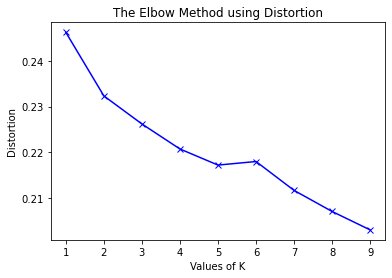

In [79]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [80]:
# run k-means clustering

#Create a function that calculates Inertia for n times
#We will sweep through 1 to n to find the optimal cluster number

def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=71).fit(X)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n

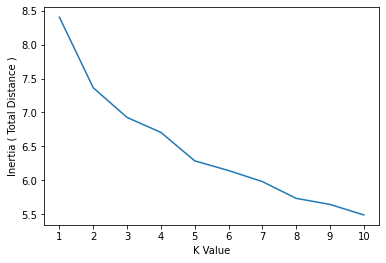

In [81]:
variances,K,n=cluster_variance(10)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

SEATTLE

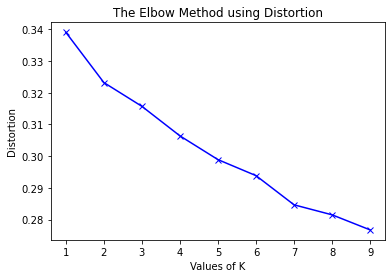

In [82]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(Y)
    kmeanModel.fit(Y)
 
    distortions.append(sum(np.min(cdist(Y, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / Y.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(Y, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / Y.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [83]:
# run k-means clustering

#Create a function that calculates Inertia for n times
#We will sweep through 1 to n to find the optimal cluster number

def cluster_variance(n):
    variances2=[]
    kmeans2=[]
    outputs2=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance2=0
        model2=KMeans(n_clusters=i,random_state=71).fit(Y)
        kmeans2.append(model2)
        variances2.append(model2.inertia_)
        
    return variances2,K,n

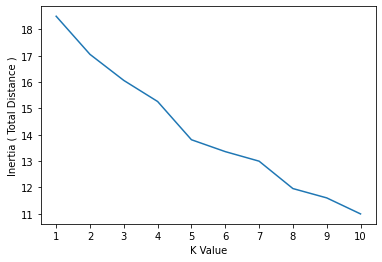

In [84]:
variances2,K,n=cluster_variance(10)
plt.plot(K,variances2)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

#### Clustering SAN FRANCISCO

Then, a reasonable number of clusters (k) seems to be at 6...

In [85]:
# set number of clusters
kclusters = 6

#san_francisco_grouped_clustering = san_francisco_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(san_francisco_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 0, 3, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood. Now we know which cluster each neighborhood belongs to.

In [86]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

san_francisco_merged = df_sf

# merge san_francisco_grouped with df_sf to add latitude/longitude for each neighborhood
san_francisco_merged = san_francisco_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

san_francisco_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,37.77722,-122.43146,3,Park,Dog Run,Playground,Coffee Shop,Spiritual Center,Food Truck,French Restaurant,Bus Line,Sushi Restaurant,Café
1,Anza Vista,37.78048,-122.44358,0,Café,Coffee Shop,Big Box Store,Tunnel,Sandwich Place,Pet Store,Bus Stop,Health & Beauty Service,Donut Shop,Cosmetics Shop
2,Ashbury Heights,37.76487,-122.44590,0,Trail,Breakfast Spot,Wine Bar,Convenience Store,Coffee Shop,Organic Grocery,Toy / Game Store,Restaurant,Bakery,Bar
3,Balboa Hollow,37.77589,-122.49360,0,Chinese Restaurant,Café,Japanese Restaurant,Bakery,Bus Station,Sporting Goods Shop,Pizza Place,Flower Shop,Vietnamese Restaurant,Dessert Shop
4,Balboa Terrace,37.73180,-122.46740,3,Yoga Studio,Comic Shop,Baseball Field,Gym,Pharmacy,Light Rail Station,Park,Vietnamese Restaurant,Fountain,Playground


Finally, let's visualize the resulting clusters

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for  lat, lon, poi, cluster in zip(san_francisco_merged['Latitude'], san_francisco_merged['Longitude'], san_francisco_merged['Neighborhood'], san_francisco_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clustering SEATTLE

Then, a reasonable number of clusters (k) seems to be at 6...

In [90]:
# set number of clusters
kclusters = 6

#seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 2, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood. Now we know which cluster each neighborhood belongs to.

In [91]:
# add clustering labels
neighborhoods_venues2_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = df_se

# merge seattle_grouped with df_se to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues2_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Seattle,47.643724,-122.302937,0,Bus Stop,Salon / Barbershop,Library,Grocery Store,Canal,Trail,Coffee Shop,Harbor / Marina,Bike Shop,Park
1,Broadview,47.722380,-122.364980,3,Trail,Concert Hall,Women's Store,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
2,Bitter Lake,47.718680,-122.350300,0,Marijuana Dispensary,Automotive Shop,Intersection,Hardware Store,Sandwich Place,Sushi Restaurant,Thai Restaurant,Beer Bar,Donut Shop,Steakhouse
3,North Beach / Blue Ridge,47.700440,-122.384180,1,Garden Center,Photography Studio,Café,Park,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Ethiopian Restaurant
4,Crown Hill,47.695200,-122.374100,0,Coffee Shop,Pizza Place,Sports Bar,Grocery Store,Pet Store,Rock Club,Sandwich Place,Fast Food Restaurant,Bus Station,Burger Joint


In [90]:
#seattle_merged 

I've noticed that certain neigborhoods have no information, as they don't return venues. So my dataframe has NaN values. I delete these neighborhoods for better analysis.

In [91]:
# Dropping cells with unassigned venues (NaN)
seattle_merged.dropna(subset=['Cluster Labels'], inplace=True)

In [92]:
seattle_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Seattle,47.643724,-122.302937,0.0,Bus Stop,Grocery Store,Italian Restaurant,Library,Park,Canal,Trail,Harbor / Marina,Coffee Shop,Bike Shop
1,Broadview,47.722380,-122.364980,4.0,Concert Hall,Trail,Women's Store,Field,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
2,Bitter Lake,47.718680,-122.350300,0.0,Marijuana Dispensary,Automotive Shop,Donut Shop,Hardware Store,Sandwich Place,Sushi Restaurant,Beer Bar,Thai Restaurant,Steakhouse,Dive Bar
3,North Beach / Blue Ridge,47.700440,-122.384180,6.0,Park,Construction & Landscaping,Café,Bus Stop,Garden Center,Women's Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
4,Crown Hill,47.695200,-122.374100,0.0,Pizza Place,Mexican Restaurant,Greek Restaurant,Pet Store,Coffee Shop,Park,Rock Club,Sandwich Place,Bus Station,Fast Food Restaurant
5,Greenwood,47.690820,-122.355290,0.0,Coffee Shop,Mexican Restaurant,Spa,Bar,Pizza Place,Diner,Comic Shop,Supermarket,Steakhouse,French Restaurant
6,Northgate,47.713100,-122.319300,0.0,Arts & Crafts Store,Yoga Studio,Coffee Shop,Taco Place,Dog Run,Greek Restaurant,Chiropractor,Pet Service,Jewelry Store,Supermarket
7,Haller Lake,47.723200,-122.338700,0.0,Soccer Field,Bakery,Japanese Restaurant,Chinese Restaurant,Café,Tennis Court,Furniture / Home Store,Grocery Store,Gym,Juice Bar
8,Pinehurst,47.718940,-122.314000,0.0,Coffee Shop,Pizza Place,Kids Store,Convenience Store,Park,Rock Club,Sandwich Place,Bus Stop,Smoke Shop,Locksmith
9,North College Park\n(Licton Springs),47.698550,-122.337630,0.0,College Theater,Advertising Agency,Community College,Bus Station,Park,Coffee Shop,Field,Ethiopian Restaurant,Event Space,Falafel Restaurant


In [92]:
#Cluster Labels column to INT type...
seattle_merged['Cluster Labels']=seattle_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters

In [93]:
# create map
map_clusters = folium.Map(location=[latitude2, longitude2], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for  lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### 3.2.5 STEP 5: Numerical & Examination

We examine each cluster in both cities and determine the discriminating venue categories that distinguish each one. 
Based on the defining categories, we evaluate according the factors established at the beginning of this report.

Creating functions to examine most common boroughs and venues in each cluster

In [94]:
def top_neighborhoods(cluster):
    """
    returns the count of the  top 'x' neighborhoods in terms of venues in a certain cluster
    """
    top_neigh = cluster['Neighborhood'].value_counts().to_frame().reset_index()
    
    top_neigh.rename(columns={'index':'neighborhood', 'Neighborhood':'count'}, inplace = True)

    
    return top_neigh

In [95]:
def top_venue_types(cluster, num_of_venues):
    """
    returns the count of the  top 'x' types of venues in a certain cluster
    """
    cluster_columns = [col for col in cluster.columns if col.endswith('Most Common Venue')]
    cluster_top = cluster[cluster_columns].stack().value_counts().to_frame().reset_index()
    cluster_top.rename(columns={'index':'venue_type', 0:'count'}, inplace = True)
    cluster_topx = cluster_top.head(num_of_venues)
    
    return cluster_topx

In [96]:
def plot_top_venues(cluster_top_venues, cluster_num):
    '''
    Create bar graph for most common venues in a cluster
    '''
    fig = plt.figure(figsize = (10,5))

    splot = sns.barplot(x = 'count', y = 'venue_type', data = cluster_top_venues, palette = 'colorblind')

    title = "Most Common Venues in Cluster {}".format(cluster_num)
    
    plt.title(label = title, size = 16)
    plt.xlabel("Count", size = 14)
    plt.ylabel("Venue Type", size = 14)

    for index, value in enumerate(cluster_top_venues['count']):
        label = value
        plt.annotate(label, xy = (value+0.01, index+0.1))

    plt.show()

In [97]:
#san_francisco_venues[san_francisco_venues['Venue']].value_counts()
san_francisco_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Alamo Square                    26
Anza Vista                      18
Ashbury Heights                 39
Balboa Hollow                   50
Balboa Terrace                  10
Belden Place                    50
Bernal Heights                  37
Buena Vista                     50
Butchertown (Old and New)       50
Cayuga Terrace                  45
China Basin                     50
Chinatown                       50
Civic Center                    50
Clarendon Heights               16
Cole Valley                     47
Corona Heights                  38
Cow Hollow                      50
Crocker-Amazon                   6
Design District                 50
Diamond Heights                 16
Dogpatch                        50
Dolores Heights                 42
Duboce Triangle                 50
Eureka Valley                   48
Fisherman's Wharf               35
Forest Hill                      7
Forest Knolls                    5
Glen Park                       16
Golden 

In [98]:
#sf_count = san_francisco_venues.groupby('Neighborhood')['Venue'].count().to_frame().reset_index()
#sf_count

#### SAN FRANCISCO

#### Cluster 0

In [100]:
clust_0= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 0, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [101]:
clust_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Anza Vista,Café,Coffee Shop,Big Box Store,Tunnel,Sandwich Place,Pet Store,Bus Stop,Health & Beauty Service,Donut Shop,Cosmetics Shop
2,Ashbury Heights,Trail,Breakfast Spot,Wine Bar,Convenience Store,Coffee Shop,Organic Grocery,Toy / Game Store,Restaurant,Bakery,Bar
3,Balboa Hollow,Chinese Restaurant,Café,Japanese Restaurant,Bakery,Bus Station,Sporting Goods Shop,Pizza Place,Flower Shop,Vietnamese Restaurant,Dessert Shop
5,The Bayview,Southern / Soul Food Restaurant,Bakery,Light Rail Station,Bus Station,Mexican Restaurant,Park,Latin American Restaurant,Café,Grocery Store,Gym
6,Belden Place,Coffee Shop,Sushi Restaurant,Restaurant,Bubble Tea Shop,French Restaurant,Japanese Restaurant,Gym,Cosmetics Shop,Food Truck,Lounge
7,Bernal Heights,Park,Coffee Shop,Italian Restaurant,Playground,Trail,Gourmet Shop,Bakery,Yoga Studio,New American Restaurant,Grocery Store
8,Buena Vista,Seafood Restaurant,Chocolate Shop,Historic Site,Ice Cream Shop,Park,Diner,Gift Shop,Beer Garden,Tour Provider,Food & Drink Shop
9,Butchertown (Old and New),French Restaurant,Coffee Shop,Poke Place,Vegetarian / Vegan Restaurant,Cocktail Bar,Concert Hall,New American Restaurant,Restaurant,Butcher,Music School
10,The Castro,Gay Bar,Thai Restaurant,Coffee Shop,Indian Restaurant,Deli / Bodega,Wine Bar,Sandwich Place,Pilates Studio,Dessert Shop,Cycle Studio
11,Cayuga Terrace,Mexican Restaurant,Sandwich Place,Bakery,Bank,Bar,Restaurant,Vietnamese Restaurant,Latin American Restaurant,Grocery Store,Thrift / Vintage Store


In [174]:
clust_0.count()

Neighborhood              94
1st Most Common Venue     94
2nd Most Common Venue     94
3rd Most Common Venue     94
4th Most Common Venue     94
5th Most Common Venue     94
6th Most Common Venue     94
7th Most Common Venue     94
8th Most Common Venue     94
9th Most Common Venue     94
10th Most Common Venue    94
dtype: int64

In [102]:
c0_neigh = top_neighborhoods(clust_0)
c0_neigh

,neighborhood,count
0,Lakeshore,1
1,The Embarcadero,1
2,Saint Francis Wood,1
3,North of Panhandle,1
4,Lakeside,1
5,Dogpatch,1
6,The Haight,1
7,The Mission,1
8,The Financial District South,1
9,Cayuga Terrace,1


In [103]:
clust0_top10 = top_venue_types(clust_0, 10)
clust0_top10

,venue_type,count
0,Coffee Shop,49
1,Bakery,28
2,Café,27
3,Yoga Studio,22
4,Grocery Store,22
5,Park,21
6,Wine Bar,17
7,Pizza Place,17
8,Gym,16
9,Thai Restaurant,15


In [196]:
clust0_top10.sum()

venue_type    Coffee ShopBakeryCaféYoga StudioGrocery StoreP...
count                                                       234
dtype: object

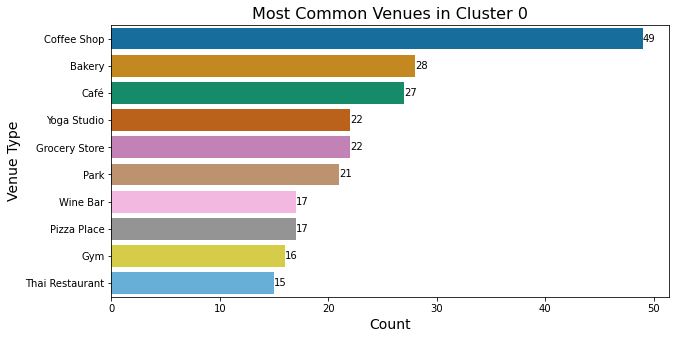

In [104]:
plot_top_venues(clust0_top10, 0)

#### Cluster 1

In [105]:
clust_1= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 1, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [106]:
clust_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Clarendon Heights,Trail,Park,Convenience Store,Grocery Store,Bus Stop,Art Gallery,Road,Reservoir,Intersection,Wine Bar
33,Forest Knolls,Trail,Playground,Tennis Court,Garden,French Restaurant,Flower Shop,Event Space,Exhibit,Fabric Shop,Farmers Market
35,Golden Gate Heights,Trail,Park,Tennis Court,Video Game Store,Playground,Scenic Lookout,Event Service,Event Space,Exhibit,Fabric Shop
70,Monterey Heights,Trail,Fountain,Park,Scenic Lookout,Bus Line,Frame Store,Filipino Restaurant,Frozen Yogurt Shop,Fabric Shop,Farmers Market
94,Sherwood Forest,Trail,Park,Gym,Mountain,Monument / Landmark,Bus Stop,Fondue Restaurant,Farmers Market,Fast Food Restaurant,Field
108,Upper Market,Park,Trail,Shoe Store,Wine Bar,Convenience Store,Grocery Store,Szechuan Restaurant,Monument / Landmark,Road,Field
114,Yerba Buena,Trail,Park,Fountain,Yoga Studio,Flower Shop,Exhibit,Fabric Shop,Farmers Market,Fast Food Restaurant,Field


In [175]:
clust_1.count()

Neighborhood              7
1st Most Common Venue     7
2nd Most Common Venue     7
3rd Most Common Venue     7
4th Most Common Venue     7
5th Most Common Venue     7
6th Most Common Venue     7
7th Most Common Venue     7
8th Most Common Venue     7
9th Most Common Venue     7
10th Most Common Venue    7
dtype: int64

In [107]:
c1_neigh = top_neighborhoods(clust_1)
c1_neigh

,neighborhood,count
0,Forest Knolls,1
1,Clarendon Heights,1
2,Golden Gate Heights,1
3,Upper Market,1
4,Monterey Heights,1
5,Sherwood Forest,1
6,Yerba Buena,1


In [108]:
clust1_top10 = top_venue_types(clust_1, 10)
clust1_top10

,venue_type,count
0,Trail,7
1,Park,6
2,Fabric Shop,4
3,Farmers Market,4
4,Field,3
5,Exhibit,3
6,Road,2
7,Wine Bar,2
8,Scenic Lookout,2
9,Monument / Landmark,2


In [198]:
clust1_top10.sum()

venue_type    TrailParkFabric ShopFarmers MarketFieldExhibit...
count                                                        35
dtype: object

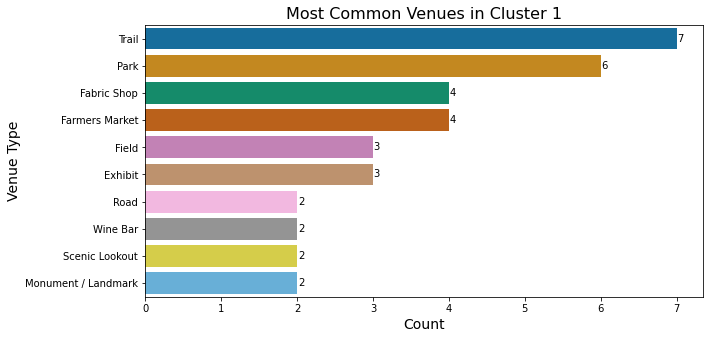

In [109]:
plot_top_venues(clust1_top10, 1)

#### Cluster 2

In [110]:
clust_2= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 2, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [111]:
clust_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,Sunnydale,Mexican Restaurant,Pet Store,Pool,Liquor Store,Yoga Studio,Fondue Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Field


In [112]:
c2_neigh = top_neighborhoods(clust_2)
c2_neigh

,neighborhood,count
0,Sunnydale,1


In [113]:
clust2_top10 = top_venue_types(clust_2, 10)
clust2_top10

,venue_type,count
0,Pet Store,1
1,Mexican Restaurant,1
2,Fondue Restaurant,1
3,Liquor Store,1
4,Yoga Studio,1
5,Farmers Market,1
6,Fast Food Restaurant,1
7,Field,1
8,Fabric Shop,1
9,Pool,1


In [199]:
clust2_top10.sum()

venue_type    Pet StoreMexican RestaurantFondue RestaurantLi...
count                                                        10
dtype: object

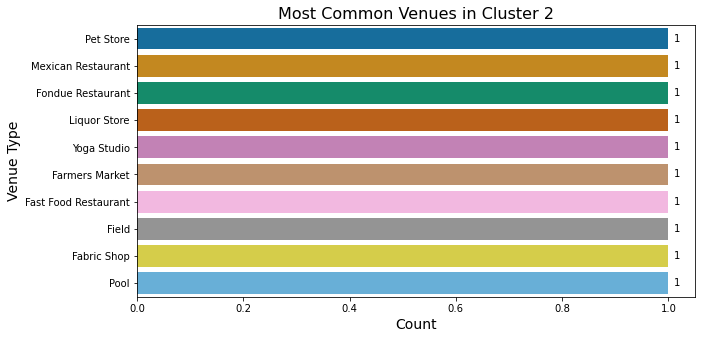

In [114]:
plot_top_venues(clust2_top10, 2)

#### Cluster 3

In [115]:
clust_3= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 3, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [116]:
clust_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,Park,Dog Run,Playground,Coffee Shop,Spiritual Center,Food Truck,French Restaurant,Bus Line,Sushi Restaurant,Café
4,Balboa Terrace,Yoga Studio,Comic Shop,Baseball Field,Gym,Pharmacy,Light Rail Station,Park,Vietnamese Restaurant,Fountain,Playground
21,Diamond Heights,Bus Station,Dim Sum Restaurant,Park,Grocery Store,Trail,Shopping Mall,Salon / Barbershop,Athletics & Sports,Coffee Shop,Pharmacy
34,Glen Park,Trail,Park,Italian Restaurant,Bookstore,Sushi Restaurant,Gift Shop,Business Service,Gym,Cheese Shop,Bakery
38,Hunters Point,Park,Brewery,Skate Park,Liquor Store,Waterfront,Coffee Shop,Yoga Studio,Flower Shop,Fabric Shop,Farmers Market
41,Ingleside Terraces,Chinese Restaurant,Playground,Park,Gym / Fitness Center,Café,Light Rail Station,Convenience Store,Yoga Studio,Noodle House,Japanese Restaurant
44,Islais Creek,Moving Target,Restaurant,Garden Center,Building,Theater,Park,Furniture / Home Store,Asian Restaurant,Light Rail Station,Music Venue
48,Laguna Honda,Light Rail Station,Playground,Bus Stop,Hotpot Restaurant,Event Space,Trail,Tennis Court,Art Gallery,Lake,Park
54,Little Hollywood,Light Rail Station,Park,Train Station,Sandwich Place,American Restaurant,Coffee Shop,Yoga Studio,Filipino Restaurant,Exhibit,Fabric Shop
62,Merced Manor,Playground,Food Truck,Music Venue,Art Gallery,Farmers Market,Gym,High School,Weight Loss Center,Food Stand,Dog Run


In [177]:
clust_3.count()

Neighborhood              20
1st Most Common Venue     20
2nd Most Common Venue     20
3rd Most Common Venue     20
4th Most Common Venue     20
5th Most Common Venue     20
6th Most Common Venue     20
7th Most Common Venue     20
8th Most Common Venue     20
9th Most Common Venue     20
10th Most Common Venue    20
dtype: int64

In [117]:
c3_neigh = top_neighborhoods(clust_3)
c3_neigh

,neighborhood,count
0,Laguna Honda,1
1,Potrero Hill,1
2,Hunters Point,1
3,Merced Manor,1
4,Ingleside Terraces,1
5,Islais Creek,1
6,Balboa Terrace,1
7,Little Hollywood,1
8,University Mound,1
9,Midtown Terrace,1


In [118]:
clust3_top10 = top_venue_types(clust_3, 10)
clust3_top10

,venue_type,count
0,Park,16
1,Playground,12
2,Yoga Studio,11
3,Farmers Market,9
4,Fabric Shop,6
5,Coffee Shop,6
6,Light Rail Station,6
7,Trail,5
8,Filipino Restaurant,5
9,Fast Food Restaurant,5


In [206]:
clust3_top10.sum()

venue_type    ParkPlaygroundYoga StudioFarmers MarketFabric ...
count                                                        81
dtype: object

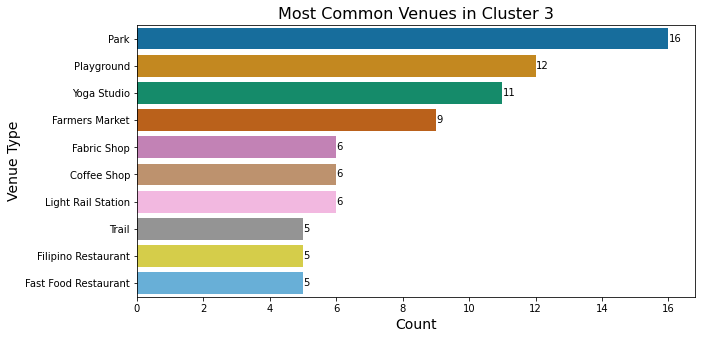

In [119]:
plot_top_venues(clust3_top10, 3)

#### Cluster 4

In [120]:
clust_4= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 4, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [121]:
clust_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,Little Russia,Baseball Field,Bowling Green,Playground,Bakery,Furniture / Home Store,Food,Farmers Market,Fast Food Restaurant,Garden Center,Field


In [122]:
c4_neigh = top_neighborhoods(clust_4)
c4_neigh

,neighborhood,count
0,Little Russia,1


In [123]:
clust4_top10 = top_venue_types(clust_4, 10)
clust4_top10

,venue_type,count
0,Food,1
1,Baseball Field,1
2,Garden Center,1
3,Furniture / Home Store,1
4,Farmers Market,1
5,Bakery,1
6,Fast Food Restaurant,1
7,Bowling Green,1
8,Field,1
9,Playground,1


In [207]:
clust4_top10.sum()

venue_type    FoodBaseball FieldGarden CenterFurniture / Hom...
count                                                        10
dtype: object

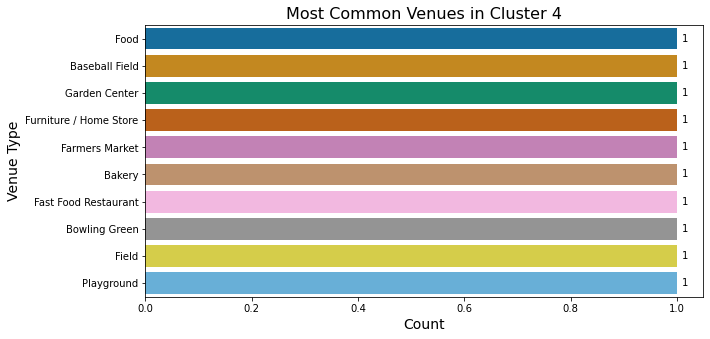

In [124]:
plot_top_venues(clust4_top10, 4)

#### Cluster 5

In [125]:
clust_5= san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 5, san_francisco_merged.columns[[0] + list(range(4, san_francisco_merged.shape[1]))]]

In [126]:
clust_5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Forest Hill,Park,Japanese Restaurant,Tennis Court,French Restaurant,Playground,Hotpot Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Field
39,India Basin,Park,Home Service,Yoga Studio,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flower Shop
61,Merced Heights,Playground,Racetrack,Park,Liquor Store,Light Rail Station,Fondue Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Field
71,Mount Davidson,Park,Tree,Playground,Monument / Landmark,Bus Line,Yoga Studio,Fondue Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant


In [127]:
c5_neigh = top_neighborhoods(clust_5)
c5_neigh

,neighborhood,count
0,Mount Davidson,1
1,Forest Hill,1
2,India Basin,1
3,Merced Heights,1


In [131]:
clust5_top10 = top_venue_types(clust_5, 10)
clust5_top10

,venue_type,count
0,Park,4
1,Farmers Market,4
2,Fast Food Restaurant,4
3,Fabric Shop,4
4,Field,3
5,Playground,3
6,Yoga Studio,2
7,Fondue Restaurant,2
8,Event Space,1
9,French Restaurant,1


In [195]:
clust5_top10.sum()

venue_type    ParkFarmers MarketFast Food RestaurantFabric S...
count                                                        28
dtype: object

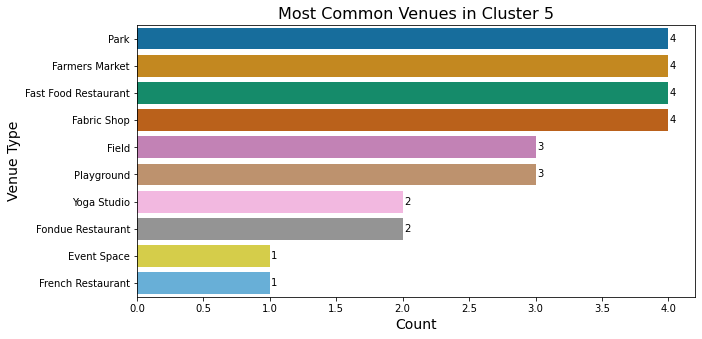

In [132]:
plot_top_venues(clust5_top10, 5)

#### SEATTLE

#### Cluster 0

In [139]:
clust_0se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [140]:
clust_0se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Seattle,Bus Stop,Salon / Barbershop,Library,Grocery Store,Canal,Trail,Coffee Shop,Harbor / Marina,Bike Shop,Park
2,Bitter Lake,Marijuana Dispensary,Automotive Shop,Intersection,Hardware Store,Sandwich Place,Sushi Restaurant,Thai Restaurant,Beer Bar,Donut Shop,Steakhouse
4,Crown Hill,Coffee Shop,Pizza Place,Sports Bar,Grocery Store,Pet Store,Rock Club,Sandwich Place,Fast Food Restaurant,Bus Station,Burger Joint
5,Greenwood,Coffee Shop,Bar,Mexican Restaurant,Spa,Pizza Place,Brewery,Supermarket,French Restaurant,Steakhouse,Lounge
6,Northgate,Arts & Crafts Store,Yoga Studio,Video Store,Taco Place,Chiropractor,Greek Restaurant,Dog Run,Pet Service,Coffee Shop,Supermarket
7,Haller Lake,Soccer Field,Bakery,Pet Store,Café,Furniture / Home Store,Chinese Restaurant,Tennis Court,Grocery Store,Gym,Track
8,Pinehurst,Coffee Shop,Kids Store,Bus Stop,Bar,Sandwich Place,Thai Restaurant,Bakery,Park,Sushi Restaurant,Rock Club
10,Maple Leaf,Coffee Shop,Thai Restaurant,Pharmacy,Arts & Crafts Store,Field,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
12,Cedar Park,Park,Moving Target,Brewery,School,Recreation Center,Supermarket,Vietnamese Restaurant,Middle Eastern Restaurant,Farmers Market,Martial Arts School
14,Meadowbrook,Pizza Place,Soccer Field,Asian Restaurant,Tennis Court,Marijuana Dispensary,Music Store,Hobby Shop,Gas Station,Dessert Shop,Health & Beauty Service


In [173]:
clust_0se.count()

Neighborhood              94
1st Most Common Venue     94
2nd Most Common Venue     94
3rd Most Common Venue     94
4th Most Common Venue     94
5th Most Common Venue     94
6th Most Common Venue     94
7th Most Common Venue     94
8th Most Common Venue     94
9th Most Common Venue     94
10th Most Common Venue    94
dtype: int64

In [141]:
c0se_neigh = top_neighborhoods(clust_0se)
c0se_neigh

,neighborhood,count
0,Georgetown,1
1,First Hill,1
2,Briarcliff,1
3,Seward Park,1
4,Central Waterfront,1
5,Rainier Beach / Atlantic City Beach,1
6,University District (U District),1
7,Judkins Park,1
8,"Central Area[120] / Central District (""CD"")",1
9,Junction[154] / West Seattle Junction / Alaska...,1


In [142]:
clust0se_top10 = top_venue_types(clust_0se, 10)
clust0se_top10

,venue_type,count
0,Coffee Shop,54
1,Café,28
2,Pizza Place,23
3,Bar,21
4,Park,20
5,Sushi Restaurant,19
6,Mexican Restaurant,19
7,Bakery,19
8,Yoga Studio,16
9,Thai Restaurant,16


In [197]:
clust0se_top10.sum()

venue_type    Coffee ShopCaféPizza PlaceBarParkSushi Restaur...
count                                                       235
dtype: object

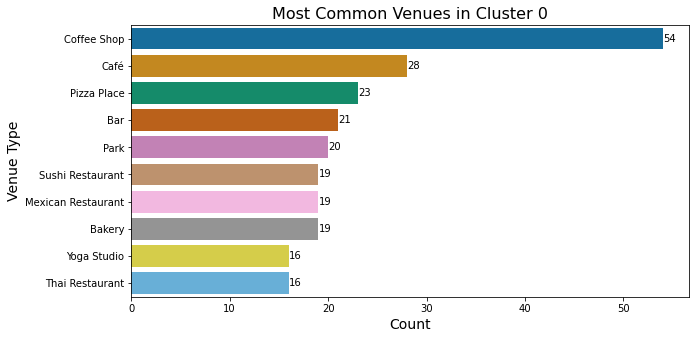

In [143]:
plot_top_venues(clust0se_top10, 0)

#### Cluster 1

In [144]:
clust_1se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [145]:
clust_1se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North Beach / Blue Ridge,Garden Center,Photography Studio,Café,Park,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Ethiopian Restaurant
9,North College Park\n(Licton Springs),College Theater,Park,Advertising Agency,Bus Stop,Community College,Women's Store,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
13,Matthews Beach,Park,Trail,Playground,Women's Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market
16,Victory Heights,Garden,Park,Beach,Marijuana Dispensary,Playground,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
18,View Ridge,Park,Bus Stop,Women's Store,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
20,Roosevelt,Park,Grocery Store,Optical Shop,Latin American Restaurant,Coffee Shop,Gas Station,Financial or Legal Service,Filipino Restaurant,Fish & Chips Shop,Field
24,Hawthorne Hills,Trail,Park,Nature Preserve,Playground,Arts & Crafts Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant
28,Wallingford,Park,Seafood Restaurant,Boat or Ferry,Food Truck,Lounge,Food,Lawyer,Massage Studio,Café,Harbor / Marina
31,Fremont,Park,Food,Coffee Shop,Gas Station,Grocery Store,Bus Stop,Bus Station,Mexican Restaurant,General Travel,Volleyball Court
41,Lawton Park,Food Truck,Playground,Grocery Store,Park,Gas Station,Coffee Shop,Financial or Legal Service,Filipino Restaurant,Fish & Chips Shop,Field


In [176]:
clust_1se.count()

Neighborhood              22
1st Most Common Venue     22
2nd Most Common Venue     22
3rd Most Common Venue     22
4th Most Common Venue     22
5th Most Common Venue     22
6th Most Common Venue     22
7th Most Common Venue     22
8th Most Common Venue     22
9th Most Common Venue     22
10th Most Common Venue    22
dtype: int64

In [146]:
c1se_neigh = top_neighborhoods(clust_1se)
c1se_neigh

,neighborhood,count
0,Roxhill,1
1,South Beacon Hill[146] / Van Asselt,1
2,North Beach / Blue Ridge,1
3,Lakewood,1
4,Matthews Beach,1
5,View Ridge,1
6,North Delridge,1
7,Victory Heights,1
8,Mount Baker,1
9,Fremont,1


In [147]:
clust1se_top10 = top_venue_types(clust_1se, 10)
clust1se_top10

,venue_type,count
0,Park,22
1,Falafel Restaurant,13
2,Eye Doctor,12
3,Event Space,11
4,Fast Food Restaurant,11
5,Farmers Market,11
6,Ethiopian Restaurant,8
7,Coffee Shop,8
8,Playground,7
9,Women's Store,6


In [200]:
clust1se_top10.sum()

venue_type    ParkFalafel RestaurantEye DoctorEvent SpaceFas...
count                                                       109
dtype: object

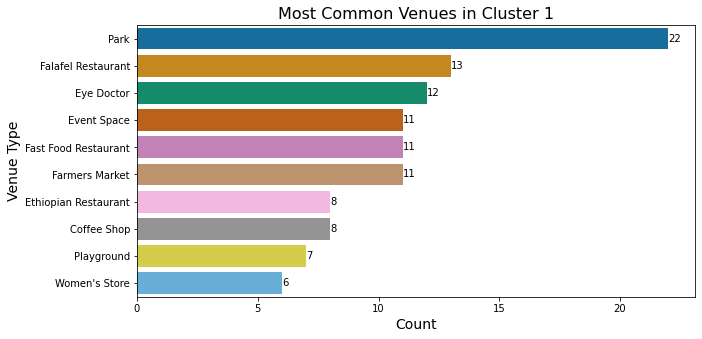

In [148]:
plot_top_venues(clust1se_top10, 1)

#### Cluster 2

In [149]:
clust_2se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [150]:
clust_2se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
114,Arbor Heights,Spa,Women's Store,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


In [151]:
c2se_neigh = top_neighborhoods(clust_2se)
c2se_neigh

,neighborhood,count
0,Arbor Heights,1


In [152]:
clust2se_top10 = top_venue_types(clust_2se, 10)
clust2se_top10

,venue_type,count
0,Falafel Restaurant,1
1,Financial or Legal Service,1
2,Event Space,1
3,Women's Store,1
4,Farmers Market,1
5,Filipino Restaurant,1
6,Fast Food Restaurant,1
7,Field,1
8,Eye Doctor,1
9,Spa,1


In [201]:
clust2se_top10.sum()

venue_type    Falafel RestaurantFinancial or Legal ServiceEv...
count                                                        10
dtype: object

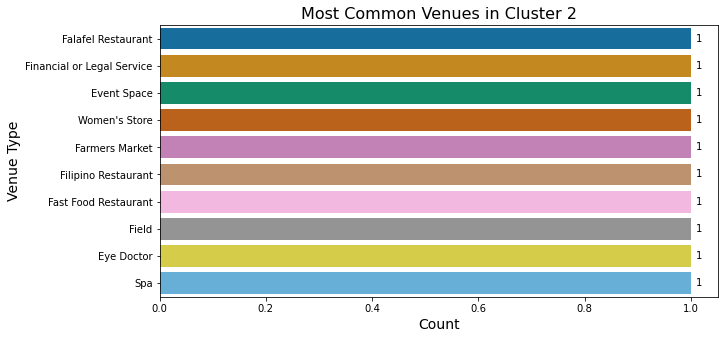

In [153]:
plot_top_venues(clust2se_top10, 2)

#### Cluster 3

In [154]:
clust_3se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [155]:
clust_3se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Broadview,Trail,Concert Hall,Women's Store,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
11,Lake City,Trail,Women's Store,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


In [156]:
c3se_neigh = top_neighborhoods(clust_3se)
c3se_neigh

,neighborhood,count
0,Broadview,1
1,Lake City,1


In [157]:
clust3se_top10 = top_venue_types(clust_3se, 10)
clust3se_top10

,venue_type,count
0,Event Space,2
1,Falafel Restaurant,2
2,Farmers Market,2
3,Trail,2
4,Women's Store,2
5,Fast Food Restaurant,2
6,Field,2
7,Eye Doctor,2
8,Concert Hall,1
9,Financial or Legal Service,1


In [202]:
clust3se_top10.sum()

venue_type    Event SpaceFalafel RestaurantFarmers MarketTra...
count                                                        18
dtype: object

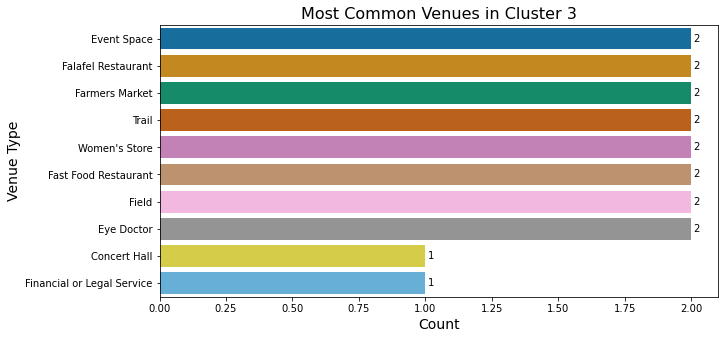

In [169]:
plot_top_venues(clust3se_top10, 3)

#### Cluster 4

In [159]:
clust_4se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [160]:
clust_4se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,Mid Beacon Hill (Maplewood),Bus Station,Light Rail Station,Scenic Lookout,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
106,Alki Point,Scenic Lookout,Coffee Shop,Park,Convenience Store,Field,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [161]:
c4se_neigh = top_neighborhoods(clust_4se)
c4se_neigh

,neighborhood,count
0,Mid Beacon Hill (Maplewood),1
1,Alki Point,1


In [162]:
clust4se_top10 = top_venue_types(clust_4se, 10)
clust4se_top10

,venue_type,count
0,Scenic Lookout,2
1,Farmers Market,2
2,Event Space,2
3,Falafel Restaurant,2
4,Fast Food Restaurant,2
5,Eye Doctor,2
6,Light Rail Station,1
7,Convenience Store,1
8,Eastern European Restaurant,1
9,Coffee Shop,1


In [203]:
clust4se_top10.sum()

venue_type    Scenic LookoutFarmers MarketEvent SpaceFalafel...
count                                                        16
dtype: object

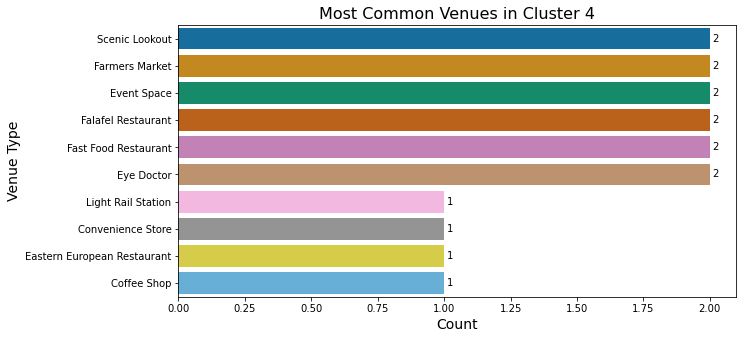

In [163]:
plot_top_venues(clust4se_top10, 4)

#### Cluster 5

In [164]:
clust_5se= seattle_merged.loc[seattle_merged['Cluster Labels'] == 5, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

In [165]:
clust_5se

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Olympic Hills,Lawyer,Pool,Women's Store,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
91,Dunlap / Othello,Wings Joint,Bakery,Pool,Baseball Field,Filipino Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field


In [166]:
c5se_neigh = top_neighborhoods(clust_5se)
c5se_neigh

,neighborhood,count
0,Olympic Hills,1
1,Dunlap / Othello,1


In [167]:
clust5se_top10 = top_venue_types(clust_5se, 10)
clust5se_top10

,venue_type,count
0,Pool,2
1,Farmers Market,2
2,Field,2
3,Falafel Restaurant,2
4,Fast Food Restaurant,2
5,Eye Doctor,2
6,Wings Joint,1
7,Lawyer,1
8,Ethiopian Restaurant,1
9,Bakery,1


In [204]:
clust5se_top10.sum()

venue_type    PoolFarmers MarketFieldFalafel RestaurantFast ...
count                                                        16
dtype: object

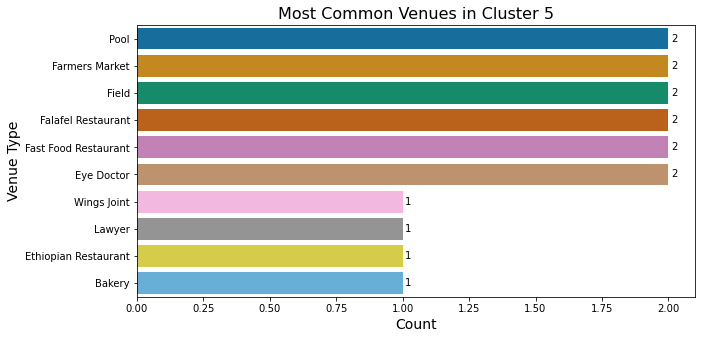

In [168]:
plot_top_venues(clust5se_top10, 5)

#### EXTRA: STUDY IN NEIGHBORHOODS IN THE SURROUNDINGS

In [ ]:
Surroundings defined by the rectangles in the paper.

Neighborhoods in the surroundings (rectangles):

* A) The Fillmore, The Western Addition, Anza Vista
* B) Butchertown (Old and New), Civic Center
* C) Hayes Valley, The Lower Haight, North of Panhandle
* D) Cole Valley, Ashbury Heights, Corona Heights
* E) Eureka Valley, The Castro, Dolores Heights

A)

In [244]:
aa = san_francisco_venues[san_francisco_venues['Neighborhood']=='The Fillmore']
aa[aa['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1094,The Fillmore,37.78392,-122.43312,Jane the Bakery,37.783797,-122.434283,Bakery


In [245]:
ab = san_francisco_venues[san_francisco_venues['Neighborhood']=='The Western Addition']
ab[ab['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3607,The Western Addition,37.78095,-122.43222,Jane the Bakery,37.783797,-122.434283,Bakery


In [246]:
ac = san_francisco_venues[san_francisco_venues['Neighborhood']=='Anza Vista']
ac[ac['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
27,Anza Vista,37.78048,-122.44358,Matching Half Cafe,37.777229,-122.441433,Café
28,Anza Vista,37.78048,-122.44358,Black/Jasmine,37.777526,-122.443268,Coffee Shop
32,Anza Vista,37.78048,-122.44358,Opa Cafe,37.784001,-122.441494,Café
38,Anza Vista,37.78048,-122.44358,Mo'z Cafe,37.782169,-122.447856,Café
40,Anza Vista,37.78048,-122.44358,Starbucks,37.782074,-122.447080,Coffee Shop


B)

In [247]:
ba = san_francisco_venues[san_francisco_venues['Neighborhood']=='Butchertown (Old and New)']
ba[ba['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
321,Butchertown (Old and New),37.77712,-122.41964,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop
332,Butchertown (Old and New),37.77712,-122.41964,Blue Bottle Coffee,37.776430,-122.423224,Coffee Shop
352,Butchertown (Old and New),37.77712,-122.41964,20th Century Cafe,37.774903,-122.422434,Café


In [249]:
bb = san_francisco_venues[san_francisco_venues['Neighborhood']=='Civic Center']
bb[bb['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
557,Civic Center,37.77863,-122.41683,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop
563,Civic Center,37.77863,-122.41683,Philz Coffee,37.781266,-122.416901,Coffee Shop
574,Civic Center,37.77863,-122.41683,Coffee Cultures,37.776089,-122.414717,Coffee Shop
582,Civic Center,37.77863,-122.41683,Arsicault Bakery,37.780789,-122.413433,Bakery
590,Civic Center,37.77863,-122.41683,All Star Cafe,37.776325,-122.414764,Café


C)

In [250]:
ca = san_francisco_venues[san_francisco_venues['Neighborhood']=='Hayes Valley']
ca[ca['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1391,Hayes Valley,37.77428,-122.42833,Ritual Coffee Roasters,37.776476,-122.424281,Coffee Shop
1400,Hayes Valley,37.77428,-122.42833,Choux Bakery™,37.771816,-122.430297,Bakery
1412,Hayes Valley,37.77428,-122.42833,Réveille Coffee Co.,37.770978,-122.432029,Coffee Shop


In [251]:
cb = san_francisco_venues[san_francisco_venues['Neighborhood']=='The Lower Haight']
cb[cb['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1977,The Lower Haight,37.77273,-122.4331,Réveille Coffee Co.,37.770978,-122.432029,Coffee Shop
1994,The Lower Haight,37.77273,-122.4331,Sightglass Coffee,37.772287,-122.437419,Coffee Shop
1999,The Lower Haight,37.77273,-122.4331,Choux Bakery™,37.771816,-122.430297,Bakery
2001,The Lower Haight,37.77273,-122.4331,Cafe International,37.772156,-122.430691,Café


In [252]:
cc = san_francisco_venues[san_francisco_venues['Neighborhood']=='North of Panhandle']
cc[cc['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2637,North of Panhandle,37.77265,-122.44586,Karma Cafe,37.773612,-122.447782,Café
2639,North of Panhandle,37.77265,-122.44586,Ritual Coffee Roasters,37.770476,-122.443791,Coffee Shop
2643,North of Panhandle,37.77265,-122.44586,Amitis Cafe,37.773958,-122.445989,Café
2653,North of Panhandle,37.77265,-122.44586,Central Coffee Tea & Spice,37.774212,-122.444427,Coffee Shop
2680,North of Panhandle,37.77265,-122.44586,Central Haight Coffee Tea & Sandwiches,37.770407,-122.444054,Café


D)

In [253]:
da = san_francisco_venues[san_francisco_venues['Neighborhood']=='Cole Valley']
da[da['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
624,Cole Valley,37.76532,-122.44987,Wooden,37.765839,-122.449952,Coffee Shop


In [254]:
db = san_francisco_venues[san_francisco_venues['Neighborhood']=='Ashbury Heights']
db[db['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
51,Ashbury Heights,37.76487,-122.4459,Wooden,37.765839,-122.449952,Coffee Shop
64,Ashbury Heights,37.76487,-122.4459,Cafe Reverie,37.766069,-122.449909,Café
66,Ashbury Heights,37.76487,-122.4459,La Boulangerie de San Francisco,37.764921,-122.449812,Bakery
72,Ashbury Heights,37.76487,-122.4459,Peet's Coffee & Tea,37.765455,-122.450063,Coffee Shop


In [255]:
dc = san_francisco_venues[san_francisco_venues['Neighborhood']=='Corona Heights']
dc[dc['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
679,Corona Heights,37.76364,-122.44039,Hot Cookie,37.762324,-122.435190,Bakery
693,Corona Heights,37.76364,-122.44039,Castro Coffee Company,37.762152,-122.435142,Coffee Shop
695,Corona Heights,37.76364,-122.44039,The Cove on Castro,37.761966,-122.435154,Café


E)

In [256]:
ea = san_francisco_venues[san_francisco_venues['Neighborhood']=='Eureka Valley']
ea[ea['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1017,Eureka Valley,37.757501,-122.437941,Neighbor's Corner,37.755513,-122.438754,Café
1021,Eureka Valley,37.757501,-122.437941,Spike's Coffee & Tea,37.759277,-122.435212,Coffee Shop
1028,Eureka Valley,37.757501,-122.437941,Philz Coffee,37.760107,-122.434792,Coffee Shop


In [257]:
eb = san_francisco_venues[san_francisco_venues['Neighborhood']=='The Castro']
eb[eb['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
357,The Castro,37.75849,-122.43477,Philz Coffee,37.760107,-122.434792,Coffee Shop
363,The Castro,37.75849,-122.43477,Spike's Coffee & Tea,37.759277,-122.435212,Coffee Shop
368,The Castro,37.75849,-122.43477,Réveille Coffee Co.,37.761104,-122.434430,Coffee Shop
403,The Castro,37.75849,-122.43477,Hot Cookie,37.762324,-122.435190,Bakery


In [258]:
ec = san_francisco_venues[san_francisco_venues['Neighborhood']=='Dolores Heights']
ec[ec['Venue Category'].str.contains("Bakery|Café|Coffee Shop")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
885,Dolores Heights,37.75828,-122.43028,Philz Coffee,37.760107,-122.434792,Coffee Shop
890,Dolores Heights,37.75828,-122.43028,Spike's Coffee & Tea,37.759277,-122.435212,Coffee Shop
893,Dolores Heights,37.75828,-122.43028,Réveille Coffee Co.,37.761104,-122.434430,Coffee Shop


for

##  4.Results & 5.Discussion & 6.Conclussion
<a name="results"></a>

please read the published paper 

Federico Sarrailh